# Spark ML example: Predicting the average rating of a film

In [1]:
import datetime

In [2]:
import findspark
findspark.init()

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import pyspark.sql.functions as F

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, RegexTokenizer, CountVectorizer, QuantileDiscretizer
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

### Create a Spark session

In [4]:
spark = SparkSession.builder.appName("movielens").master("local[2]").getOrCreate()

### Load the Movielens dataset

In [5]:
movies = spark.read.format("csv").option("header", "true").load("data/ml-20m/movies.csv")
ratings = spark.read.format("csv").option("header", "true").load("data/ml-20m/ratings.csv")

### Generate some possible features

In [6]:
averageRatingsAndReviewCounts = ratings.groupBy("movieId").agg(
    F.mean("rating").alias("averageRating"), 
    F.count("rating").alias("viewCount")
)
features = movies.join(averageRatingsAndReviewCounts, on="movieId").cache()

In [7]:
features.show(5)

+-------+--------------------+--------------------+------------------+---------+
|movieId|               title|              genres|     averageRating|viewCount|
+-------+--------------------+--------------------+------------------+---------+
|    296| Pulp Fiction (1994)|Comedy|Crime|Dram...| 4.174231169217055|    67310|
|   1090|      Platoon (1986)|           Drama|War| 3.919977226720648|    15808|
|   3959|Time Machine, The...|Action|Adventure|...| 3.699372603694667|     2869|
|   2294|         Antz (1998)|Adventure|Animati...| 3.303207714257601|    10163|
|   6731|Day of the Dead (...|Horror|Sci-Fi|Thr...|3.5571184995737424|     1173|
+-------+--------------------+--------------------+------------------+---------+
only showing top 5 rows



### Categorical features for the generations

RegexTokenizer is a transformer

In [8]:
genreTokenizer = RegexTokenizer(inputCol="genres", outputCol="genreList", pattern="\|")

featuresWithGenreList = genreTokenizer.transform(features)

featuresWithGenreList.show(5)

+-------+--------------------+--------------------+------------------+---------+--------------------+
|movieId|               title|              genres|     averageRating|viewCount|           genreList|
+-------+--------------------+--------------------+------------------+---------+--------------------+
|    296| Pulp Fiction (1994)|Comedy|Crime|Dram...| 4.174231169217055|    67310|[comedy, crime, d...|
|   1090|      Platoon (1986)|           Drama|War| 3.919977226720648|    15808|        [drama, war]|
|   3959|Time Machine, The...|Action|Adventure|...| 3.699372603694667|     2869|[action, adventur...|
|   2294|         Antz (1998)|Adventure|Animati...| 3.303207714257601|    10163|[adventure, anima...|
|   6731|Day of the Dead (...|Horror|Sci-Fi|Thr...|3.5571184995737424|     1173|[horror, sci-fi, ...|
+-------+--------------------+--------------------+------------------+---------+--------------------+
only showing top 5 rows



CountVectorizer is an estimator (it produces a CountVectorizerModel that stores the encoding of genres)

In [10]:
genreVectorizer = CountVectorizer(inputCol="genreList", outputCol="encodedGenres")

genreVectorizerModel = genreVectorizer.fit(featuresWithGenreList)

featuresWithEncodedGenres = genreVectorizerModel.transform(featuresWithGenreList)

featuresWithEncodedGenres.show(5)

+-------+--------------------+--------------------+------------------+---------+--------------------+--------------------+
|movieId|               title|              genres|     averageRating|viewCount|           genreList|       encodedGenres|
+-------+--------------------+--------------------+------------------+---------+--------------------+--------------------+
|    296| Pulp Fiction (1994)|Comedy|Crime|Dram...| 4.174231169217055|    67310|[comedy, crime, d...|(20,[0,1,2,5],[1....|
|   1090|      Platoon (1986)|           Drama|War| 3.919977226720648|    15808|        [drama, war]|(20,[0,12],[1.0,1...|
|   3959|Time Machine, The...|Action|Adventure|...| 3.699372603694667|     2869|[action, adventur...|(20,[4,8,9],[1.0,...|
|   2294|         Antz (1998)|Adventure|Animati...| 3.303207714257601|    10163|[adventure, anima...|(20,[1,8,11,13,15...|
|   6731|Day of the Dead (...|Horror|Sci-Fi|Thr...|3.5571184995737424|     1173|[horror, sci-fi, ...|(20,[2,6,9],[1.0,...|
+-------+-------

### View count quantiles

QuantilesDiscretizer is an estimator (it produces a QuantileDiscretizerModel that stores the bucket mapping)

In [11]:
viewCountQuantileDiscretizer = QuantileDiscretizer(inputCol="viewCount", outputCol="viewCountBucket", numBuckets=10)

viewCountQuantileDiscretizerModel = viewCountQuantileDiscretizer.fit(features)

viewCountQuantileDiscretizerModel.transform(features).show(5)

+-------+--------------------+--------------------+------------------+---------+---------------+
|movieId|               title|              genres|     averageRating|viewCount|viewCountBucket|
+-------+--------------------+--------------------+------------------+---------+---------------+
|    296| Pulp Fiction (1994)|Comedy|Crime|Dram...| 4.174231169217055|    67310|            9.0|
|   1090|      Platoon (1986)|           Drama|War| 3.919977226720648|    15808|            9.0|
|   3959|Time Machine, The...|Action|Adventure|...| 3.699372603694667|     2869|            9.0|
|   2294|         Antz (1998)|Adventure|Animati...| 3.303207714257601|    10163|            9.0|
|   6731|Day of the Dead (...|Horror|Sci-Fi|Thr...|3.5571184995737424|     1173|            8.0|
+-------+--------------------+--------------------+------------------+---------+---------------+
only showing top 5 rows



### Combine into a pipeline

Pipeline is just a special estimator that takes a list of stages (transformers or estimators). It will run them in order calling transform or fit as appropriate.

In [12]:
pipeline = Pipeline(stages=[
    RegexTokenizer(inputCol="genres", outputCol="genreList", pattern="\|"),
    CountVectorizer(inputCol="genreList", outputCol="encodedGenres"),
    QuantileDiscretizer(inputCol="viewCount", outputCol="viewCountBucket", numBuckets=10),
    VectorAssembler(inputCols=["encodedGenres", "viewCountBucket"], outputCol="features"),
    LinearRegression(featuresCol="features", labelCol="averageRating")
])

In [13]:
model = pipeline.fit(features)

In [14]:
model.transform(features).select("title", "genres", "viewCount", "averageRating", "prediction").show(5)

+--------------------+--------------------+---------+------------------+------------------+
|               title|              genres|viewCount|     averageRating|        prediction|
+--------------------+--------------------+---------+------------------+------------------+
| Pulp Fiction (1994)|Comedy|Crime|Dram...|    67310| 4.174231169217055| 3.475449274986473|
|      Platoon (1986)|           Drama|War|    15808| 3.919977226720648|3.6463014771638766|
|Time Machine, The...|Action|Adventure|...|     2869| 3.699372603694667| 3.036707852277163|
|         Antz (1998)|Adventure|Animati...|    10163| 3.303207714257601|3.2944912951386804|
|Day of the Dead (...|Horror|Sci-Fi|Thr...|     1173|3.5571184995737424|2.7164126878673542|
+--------------------+--------------------+---------+------------------+------------------+
only showing top 5 rows



Not perfect, but there's definitely some correlation here...

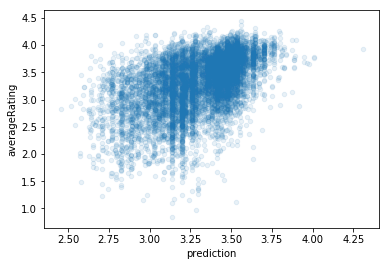

In [15]:
%matplotlib inline

preds = model.transform(features).toPandas()
preds[preds["viewCount"] > 100].plot.scatter("prediction", "averageRating", alpha=0.1)

Pulling out the coefficients is a bit painful, but it can be done.

In [ ]:
import pandas as pd
pd.DataFrame({"category": model.stages[1].vocabulary,"coefficient": model.stages[-1].coefficients[0:-1]}).sort_values("coefficient")

### Evaluation

Really easy to evaluate a model using the standard metrics. For regression we have the RegressionEvaluator which calculates the RMS error by default (can be changed).

In [ ]:
evaluator = RegressionEvaluator().setLabelCol("averageRating")

In [ ]:
evaluator.evaluate(model.transform(features))

How does that compare to a baseline model where we just use the average rating?

In [ ]:
basePipeline = Pipeline(stages=[
    VectorAssembler(inputCols=[], outputCol="features"),
    LinearRegression(featuresCol="features", labelCol="averageRating")
])

baseModel = basePipeline.fit(features)

In [ ]:
baseModel.transform(features).select("title", "genres", "viewCount", "averageRating", "prediction").show(5)

In [ ]:
evaluator.evaluate(baseModel.transform(features))

### Cross validation

Model selection via cross validation is really simple too! Just need to set the number of folds, specify a pipleine, specify an evaluator and, optionally, a set of model parameters to iterate over. CrossValidator is just a special estimator, the model it returns corresponds to the best set of parameters found.

In [ ]:
crossValidator = CrossValidator().setNumFolds(3)\
                                 .setEstimator(pipeline)\
                                 .setEvaluator(evaluator)\
                                 .setEstimatorParamMaps(ParamGridBuilder().build())

In [ ]:
crossValidatorModel = crossValidator.fit(features)

In [ ]:
crossValidatorModel.avgMetrics